In [1]:
import sys
sys.path.insert(1, '..')
sys.path.insert(2, '../modules/')
import drms
from ruffus import *
import os
import re
import pickle
import dataconfig
import warnings

warnings.filterwarnings("ignore")

from modules import convert_datetime
from modules import query_the_data
from modules import sxi_module
from modules import helio_reg_exp_module
from time import sleep
from random import randint
from astropy.time import Time
import sqlalchemy as sa
import pandas as pd

import random

import json

from datetime import datetime, timedelta

loaded libraries sxi module: 0:00:00.704306
loaded libraries sxi module: 0:00:00.000024


In [2]:
client = drms.Client()

In [3]:
def make_drms_ar_availability_filename_sharp(jsoc_query_str):

    sub2 = re.sub('hmi.sharp_720s\[', '', jsoc_query_str)

    sub3 = re.sub(' ','', sub2)

    sub4 = re.sub(']', '', sub3)

    sub5 = re.sub('\[', '', sub4)

    return(sub5)

In [4]:
def make_drms_ar_availability_filename_Mharp(jsoc_query_str):
    
    sub2 = re.sub('hmi.Mharp_720s\[', '', jsoc_query_str)

    sub3 = re.sub(' ','', sub2)

    sub4 = re.sub(']', '', sub3)

    sub5 = re.sub('\[', '', sub4)

    return(sub5)

In [5]:
def make_hmi_jsoc_availability_query_string_sharp(time_ex_1, time_ex_2):

    time_str_1 = f'{time_ex_1:%Y.%m.%d}'

    time_str_2 = f'{time_ex_2:%Y.%m.%d}'

    query_str = f'hmi.sharp_720s[][{time_str_1} - {time_str_2}]'

    return(query_str)

In [6]:
def make_hmi_jsoc_availability_query_string_Mharp(time_ex_1, time_ex_2):

    time_str_1 = f'{time_ex_1:%Y.%m.%d}'

    time_str_2 = f'{time_ex_2:%Y.%m.%d}'

    query_str = f'hmi.Mharp_720s[][{time_str_1} - {time_str_2}]'

    return(query_str)

In [7]:
def convert_TAI_to_UTC(TAI_STR):
    
    sub = re.sub('\.', '-',TAI_STR)

    sub2 = re.sub('_', 'T', sub)

    sub3 = re.sub('TTAI', '', sub2)

    t = Time(sub3, scale='tai')

    utc = t.utc

    pandas_timestamp = convert_datetime.astropytime_to_pythondatetime(utc)


    return(pandas_timestamp)

In [8]:
def test_same_dfs(harp_df, sharp_df):

    A = sharp_df[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].reset_index(drop = True)
    B = harp_df[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].dropna().reset_index(drop = True)


    diff = A[['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN', 'HARPNUM']] - B[['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN', 'HARPNUM']]

    non_zero_diff = diff[(diff != 0).any(axis=1)]

    return(len(non_zero_diff) == 0)

In [9]:
def if_test_ok_return_dfs(harp_df, sharp_df):

    A = sharp_df.reset_index(drop = True)
    B = harp_df.dropna().reset_index(drop = True)


    return(A,B)

In [10]:
def create_hmi_pix_bbox(row):

    IMCRPIX1, IMCRPIX2 = row['IMCRPIX1'], row['IMCRPIX2']
    XDIM_CCD, YDIM_CCD = row['CRSIZE1'], row['CRSIZE2']
    CRPIX1, CRPIX2 = row['CRPIX1'], row['CRPIX2']

    # print(IMCRPIX1, IMCRPIX2,XDIM_CCD, YDIM_CCD,CRPIX1, CRPIX2)

    # # lower left-hand corner
    x_min = (IMCRPIX1 + CRPIX1 - XDIM_CCD)
    y_min = (IMCRPIX2 + CRPIX2 - YDIM_CCD) 

    # upper right-hand corner
    x_max = (IMCRPIX1 + CRPIX1)
    y_max = (IMCRPIX2 + CRPIX2)


    hmi_pix_bbox = [[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min], [x_min, y_min]]

    return(hmi_pix_bbox)

In [11]:
def str_w_Z_at_end_to_pythondatetime(time_str):

    time_str_wo_Z = time_str[:-1]

    datetime_obj = datetime.strptime(time_str_wo_Z,'%Y-%m-%dT%H:%M:%S.%f' )

    return(pd.Timestamp(datetime_obj, tz = 'utc'))

In [12]:
def convert_columns_to_python_datetime(input_df):

    copy_df = input_df.copy()

    copy_df['T_OBS'] = [convert_TAI_to_UTC(tai_str) for tai_str in copy_df['T_OBS']]

    copy_df['T_FRST'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_FRST']]

    copy_df['T_FRST1'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_FRST1']]

    copy_df['T_LAST'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_LAST']]

    copy_df['T_LAST1'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_LAST1']]

    copy_df['T_REC'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_REC']]

    copy_df['DATE-OBS'] = [convert_datetime.str_w_Z_at_end_to_pythondatetime(this_z_str_datetime) for this_z_str_datetime in copy_df['DATE-OBS']]

    return(copy_df)

In [13]:
def convert_columns_to_UNIX_timestamp(input_df):

    copy_df = input_df.copy()

    copy_df['T_OBS'] = [convert_datetime.convert_datetime_to_timestamp(tai_str) for tai_str in copy_df['T_OBS']]

    copy_df['T_FRST'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_FRST']]

    copy_df['T_FRST1'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_FRST1']]

    copy_df['T_LAST'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_LAST']]

    copy_df['T_LAST1'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_LAST1']]

    copy_df['DATE-OBS'] = [convert_datetime.convert_datetime_to_timestamp(this_z_str_datetime) for this_z_str_datetime in copy_df['DATE-OBS']]

    return(copy_df)

In [14]:
def create_HGS_bbox(AR_DF_ROW):

    x_min, x_max, y_min, y_max = AR_DF_ROW.LON_MIN, AR_DF_ROW.LON_MAX, AR_DF_ROW.LAT_MIN, AR_DF_ROW.LAT_MAX

    list = [[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min], [x_min, y_min]]

    return(list)

In [15]:

# 2012.03.06_23:29:06 --- Bobras test SHARP from https://github.com/mbobra/SHARPs/blob/master/feature_extraction.ipynb

start_download_from = '2011-02-07T19:30:00'
end_download_at = '2011-02-09T22:30:00'

# start_download_from = '2012-03-06T00:00:00'
# end_download_at = '2012-03-07T00:00:00'

START_DATE_TIME = pd.Timestamp(start_download_from, tz = 'utc')

END_DATE_TIME = pd.Timestamp(end_download_at, tz = 'utc')

frequency = '1D'

datelist = pd.date_range(start = START_DATE_TIME , end = END_DATE_TIME, freq = frequency ).tolist()

this_query_list_Mharp = [make_hmi_jsoc_availability_query_string_Mharp(previous,current) for previous,current in zip(datelist[:], datelist[1:])]

this_query_list_sharp = [make_hmi_jsoc_availability_query_string_sharp(previous,current) for previous,current in zip(datelist[:], datelist[1:])]


joint_list = [[m_harp_query, sharp_query] for m_harp_query, sharp_query in zip(this_query_list_Mharp,this_query_list_sharp)]

In [16]:
joint_list

[['hmi.Mharp_720s[][2011.02.07 - 2011.02.08]',
  'hmi.sharp_720s[][2011.02.07 - 2011.02.08]'],
 ['hmi.Mharp_720s[][2011.02.08 - 2011.02.09]',
  'hmi.sharp_720s[][2011.02.08 - 2011.02.09]']]

In [17]:
jsoc_query_Mharp = joint_list[0] [0]

jsoc_query_sharp = joint_list[0][1]

jsoc_query_Mharp,jsoc_query_sharp


('hmi.Mharp_720s[][2011.02.07 - 2011.02.08]',
 'hmi.sharp_720s[][2011.02.07 - 2011.02.08]')

In [18]:
series_info_sharp = client.info("hmi.sharp_720s")
series_info_Mharp = client.info("hmi.Mharp_720s")


In [19]:
print(f"Listing keywords for {series_info_sharp.name}:\n")
for keyword in sorted(series_info_sharp.keywords.index):
    keyword_info = series_info_sharp.keywords.loc[keyword]
    print(keyword)
    print(f"  type ....... {keyword_info.type} ")
    print(f"  recscope ... {keyword_info.recscope} ")
    print(f"  defval ..... {keyword_info.defval} ")
    print(f"  units ...... {keyword_info.units} ")
    print(f"  note ....... {keyword_info.note} ")

series_info_Mharp = client.info("hmi.Mharp_720s")


Listing keywords for hmi.sharp_720s:

ABSNJZH
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... (G^2)/m 
  note ....... Absolute value of the net current helicity 
ACTIVE
  type ....... int 
  recscope ... variable 
  defval ..... -2147483648 
  units ...... none 
  note ....... Mask value for active region pixels 
AMBBTHR0
  type ....... double 
  recscope ... variable 
  defval ..... nan 
  units ...... G 
  note ....... Transverse field strength threshold at disk center for using simulated annealing 
AMBBTHR1
  type ....... double 
  recscope ... variable 
  defval ..... nan 
  units ...... G 
  note ....... Transverse field strength threshold at limb for using simulated annealing 
AMBCODEV
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... Version of Disambig code 
AMBDOCU
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... Document for Disambig code 
A

In [20]:
print(f"Listing keywords for {series_info_Mharp.name}:\n")
for keyword in sorted(series_info_Mharp.keywords.index):
    keyword_info = series_info_Mharp.keywords.loc[keyword]
    print(keyword)
    print(f"  type ....... {keyword_info.type} ")
    print(f"  recscope ... {keyword_info.recscope} ")
    print(f"  defval ..... {keyword_info.defval} ")
    print(f"  units ...... {keyword_info.units} ")
    print(f"  note ....... {keyword_info.note} ")

Listing keywords for hmi.mharp_720s:

ACTIVE
  type ....... int 
  recscope ... variable 
  defval ..... -2147483648 
  units ...... none 
  note ....... Mask value for active region pixels 
AREA
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... mH 
  note ....... De-projected area of patch on sphere in micro-hemisphere 
AREA_ACR
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... mH 
  note ....... De-projected area of active pixels on sphere in micro-hemisphere 
ARMCODEV
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... ARmask code version 
ARMDOCU
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... ARmask code documentation 
ARM_BETA
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... ARmask parameter: Mask spatial smoothness 
ARM_EDGE
  type ....... float 
  recscope ... var

In [21]:
# keys_Mharp = 'CRPIX1, CRPIX2, CRSIZE1, CRSIZE2, T_OBS, HARPNUM,  AREA_ACR, QUALITY,NOAA_NUM, NOAA_AR, NOAA_ARS,AREA, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX,T_FRST,T_LAST'
# keys_sharp = 'T_OBS, HARPNUM,  AREA_ACR, QUALITY,NOAA_NUM, NOAA_AR, NOAA_ARS,AREA, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX,T_FRST,T_LAST'


In [22]:
keys_Mharp = 'IMCRPIX1,IMCRPIX2,AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,DATE-OBS,HARPNUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,NOAA_AR,NOAA_ARS,NOAA_NUM,NPIX,QUALITY,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,T_REC, DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS '

In [23]:
keys_sharp = 'IMCRPIX1,IMCRPIX2,AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,NOAA_AR,NOAA_ARS,NOAA_NUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,ABSNJZH,AREA_ACR,TOTPOT,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,MEANPOT,MEANGAM,MEANGBH,MEANALP,MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45'


In [24]:
hmi_ar_query_df_sharp = client.query(jsoc_query_sharp, key= keys_sharp)
hmi_ar_query_df_sharp


,IMCRPIX1,IMCRPIX2,AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,...,MEANGAM,MEANGBH,MEANALP,MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45
0,2039.215576,2046.378052,2445.900146,0.504274,0.504274,180.082642,1675.215576,-392.621948,Invalid KeyLink,Invalid KeyLink,...,23.724,28.936,0.004319,89.384,89.488,0.099992,0.000939,20.240,0.000,0.977
1,2039.197144,2046.346680,2440.700684,0.504274,0.504274,180.082550,1676.197144,-392.653320,Invalid KeyLink,Invalid KeyLink,...,23.938,28.145,0.005357,87.230,87.520,0.113382,0.001122,20.325,0.000,1.095
2,2039.203369,2046.290649,2432.326172,0.504274,0.504274,180.082535,1678.203369,-392.709351,Invalid KeyLink,Invalid KeyLink,...,23.534,28.483,0.006675,88.551,88.789,0.038859,0.001441,19.897,0.000,0.886
3,2039.212646,2046.323853,2429.982422,0.504273,0.504273,180.082596,1679.212646,-392.676147,Invalid KeyLink,Invalid KeyLink,...,23.321,28.263,0.004083,88.347,88.500,0.005310,0.000885,19.615,0.000,0.636
4,2039.193848,2046.383179,2424.742920,0.504273,0.504273,180.082596,1681.193848,-393.616821,Invalid KeyLink,Invalid KeyLink,...,23.089,27.881,0.004244,87.450,87.742,0.086770,0.000917,19.428,0.000,0.442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2039.087891,2046.390259,2259.696045,0.504275,0.504275,180.082642,1772.087891,844.390259,Invalid KeyLink,Invalid KeyLink,...,33.963,42.477,-0.008834,90.564,96.181,-0.132542,-0.003387,27.507,3.910,12.040
359,2039.100830,2046.402954,2264.586670,0.504276,0.504276,180.082626,1774.100830,843.402954,Invalid KeyLink,Invalid KeyLink,...,34.480,43.120,-0.008836,89.470,95.416,-0.042951,-0.003319,27.836,3.814,12.732
360,2039.135864,2046.425537,2267.836670,0.504275,0.504275,180.082550,1775.135864,843.425537,Invalid KeyLink,Invalid KeyLink,...,34.150,42.233,-0.005218,89.051,94.413,-0.181983,-0.001974,27.685,3.727,12.368
361,2039.153931,2046.412598,2269.835693,0.504274,0.504274,180.082626,1776.153931,843.412598,Invalid KeyLink,Invalid KeyLink,...,33.953,41.720,-0.003137,88.645,92.874,-0.264312,-0.001187,27.668,3.749,12.732


In [25]:

# # lower left-hand corner
# x1 = (keys_ccd.IMCRPIX1[0] - keys_ccd.CRPIX1[0])
# y1 = (keys_ccd.IMCRPIX2[0] - keys_ccd.CRPIX2[0]) 

In [26]:
hmi_ar_query_df_sharp.HARPNUM.unique()

array([355, 361, 362])

In [27]:
hmi_ar_query_df_mharp = client.query(jsoc_query_Mharp, key= keys_Mharp)
hmi_ar_query_df_mharp

,IMCRPIX1,IMCRPIX2,AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,...,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,T_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS
0,2039.215576,2046.378052,2445.900146,0.504274,0.504274,180.082642,365.0,2440.0,421,365,...,2011.01.26_23:24:00_TAI,2011.01.27_23:24:00_TAI,2011.02.09_04:24:00_TAI,2011.02.08_04:24:00_TAI,2011.02.06_23:59:53_TAI,2011.02.07_00:00:00_TAI,1.495979e+11,1.475174e+11,696000000.0,973.179138
1,2039.197144,2046.346680,2440.700684,0.504274,0.504274,180.082550,364.0,2440.0,420,365,...,2011.01.26_23:24:00_TAI,2011.01.27_23:24:00_TAI,2011.02.09_04:24:00_TAI,2011.02.08_04:24:00_TAI,2011.02.07_00:11:53_TAI,2011.02.07_00:12:00_TAI,1.495979e+11,1.475193e+11,696000000.0,973.166626
2,2039.203369,2046.290649,2432.326172,0.504274,0.504274,180.082535,362.0,2440.0,419,365,...,2011.01.26_23:24:00_TAI,2011.01.27_23:24:00_TAI,2011.02.09_04:24:00_TAI,2011.02.08_04:24:00_TAI,2011.02.07_00:23:53_TAI,2011.02.07_00:24:00_TAI,1.495979e+11,1.475212e+11,696000000.0,973.153992
3,2039.212646,2046.323853,2429.982422,0.504273,0.504273,180.082596,361.0,2440.0,418,366,...,2011.01.26_23:24:00_TAI,2011.01.27_23:24:00_TAI,2011.02.09_04:24:00_TAI,2011.02.08_04:24:00_TAI,2011.02.07_00:35:53_TAI,2011.02.07_00:36:00_TAI,1.495979e+11,1.475232e+11,696000000.0,973.140991
4,2039.193848,2046.383179,2424.742920,0.504273,0.504273,180.082596,359.0,2441.0,418,365,...,2011.01.26_23:24:00_TAI,2011.01.27_23:24:00_TAI,2011.02.09_04:24:00_TAI,2011.02.08_04:24:00_TAI,2011.02.07_00:47:53_TAI,2011.02.07_00:48:00_TAI,1.495979e+11,1.475251e+11,696000000.0,973.127930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,2039.087891,2046.390259,NaN,0.504275,0.504275,180.082642,3327.0,2769.0,297,235,...,2011.02.07_08:12:00_TAI,2011.02.08_08:12:00_TAI,2011.02.17_10:36:00_TAI,2011.02.16_10:36:00_TAI,2011.02.07_23:11:53_TAI,2011.02.07_23:12:00_TAI,1.495979e+11,1.475341e+11,696000000.0,973.068481
1000,2039.100830,2046.402954,NaN,0.504276,0.504276,180.082626,3325.0,2769.0,298,235,...,2011.02.07_08:12:00_TAI,2011.02.08_08:12:00_TAI,2011.02.17_10:36:00_TAI,2011.02.16_10:36:00_TAI,2011.02.07_23:23:53_TAI,2011.02.07_23:24:00_TAI,1.495979e+11,1.475359e+11,696000000.0,973.057251
1001,2039.135864,2046.425537,NaN,0.504275,0.504275,180.082550,3323.0,2768.0,298,236,...,2011.02.07_08:12:00_TAI,2011.02.08_08:12:00_TAI,2011.02.17_10:36:00_TAI,2011.02.16_10:36:00_TAI,2011.02.07_23:35:53_TAI,2011.02.07_23:36:00_TAI,1.495979e+11,1.475376e+11,696000000.0,973.045593
1002,2039.153931,2046.412598,NaN,0.504274,0.504274,180.082626,3321.0,2768.0,299,236,...,2011.02.07_08:12:00_TAI,2011.02.08_08:12:00_TAI,2011.02.17_10:36:00_TAI,2011.02.16_10:36:00_TAI,2011.02.07_23:47:53_TAI,2011.02.07_23:48:00_TAI,1.495979e+11,1.475394e+11,696000000.0,973.033630


In [28]:
hmi_ar_query_df_mharp.HARPNUM.unique()

array([355, 358, 359, 361, 362, 364, 366, 367, 368, 369])

In [29]:
are_dimensions_of_dfs_the_same = test_same_dfs(hmi_ar_query_df_mharp,hmi_ar_query_df_sharp)

if are_dimensions_of_dfs_the_same:

    sharp_df, harp_df = if_test_ok_return_dfs(hmi_ar_query_df_mharp,hmi_ar_query_df_sharp)

    print('dropping Nans from m_harp give the same df as sharp')

if are_dimensions_of_dfs_the_same == False:

    print('dataframes not comparable for {}')

dropping Nans from m_harp give the same df as sharp


In [30]:
def join_dataframes(sharp_df, harp_df):

    """
    Make pixel bbox from harp_df: CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2
    Make hgs bbox from sharp_df: 

    keep_keys_sharp = 'DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,NOAA_AR,
                       NOAA_ARS,NOAA_NUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,ABSNJZH,AREA_ACR,
                       TOTPOT,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,MEANPOT,MEANGAM,MEANGBH,MEANALP,
                       MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45'

    keep_keys_Mharp = 'CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,NPIX, QUALITY,T_REC'
    
    """

    keep_keys_sharp = ['DATE-OBS','HARPNUM','T_FRST','T_FRST1','T_LAST','T_LAST1','T_OBS','NOAA_AR',
                       'NOAA_ARS','NOAA_NUM','LAT_MAX','LAT_MIN','LON_MAX','LON_MIN','ABSNJZH','AREA_ACR',
                       'TOTPOT','TOTUSJH','TOTUSJZ','SAVNCPP','USFLUX','MEANPOT','MEANGAM','MEANGBH','MEANALP',
                       'MEANGBT','MEANGBZ','MEANJZD','MEANJZH','MEANSHR','R_VALUE','SHRGT45',
                       'IMCRPIX1', 'IMCRPIX2','CDELT1','CDELT2','CROTA2','CRPIX1','CRPIX2']

    keep_keys_Mharp = ['NPIX', 'QUALITY','T_REC', 'DSUN_REF','DSUN_OBS','RSUN_REF','RSUN_OBS','CRSIZE1','CRSIZE2']

    masked_sharp = sharp_df[keep_keys_sharp]

    masked_mharp = harp_df[keep_keys_Mharp]

    return(pd.concat([masked_sharp,masked_mharp], axis = 1))


    



In [31]:
joined_sharp_mharp_df = join_dataframes(sharp_df, harp_df)

In [32]:
joined_copy = joined_sharp_mharp_df.copy()

joined_copy['hgs_bbox'] = [create_HGS_bbox(row) for row in joined_copy.itertuples()]



In [33]:
joined_date_time = convert_columns_to_python_datetime(joined_copy)

In [34]:
joined_time_stamp = convert_columns_to_UNIX_timestamp(joined_date_time)

In [35]:
joined_time_stamp['NOAA_ARS'] = [re.split(r',',this_str_list) for this_str_list in joined_time_stamp['NOAA_ARS']]

In [36]:
joined_time_stamp.columns

Index(['DATE-OBS', 'HARPNUM', 'T_FRST', 'T_FRST1', 'T_LAST', 'T_LAST1',
       'T_OBS', 'NOAA_AR', 'NOAA_ARS', 'NOAA_NUM', 'LAT_MAX', 'LAT_MIN',
       'LON_MAX', 'LON_MIN', 'ABSNJZH', 'AREA_ACR', 'TOTPOT', 'TOTUSJH',
       'TOTUSJZ', 'SAVNCPP', 'USFLUX', 'MEANPOT', 'MEANGAM', 'MEANGBH',
       'MEANALP', 'MEANGBT', 'MEANGBZ', 'MEANJZD', 'MEANJZH', 'MEANSHR',
       'R_VALUE', 'SHRGT45', 'IMCRPIX1', 'IMCRPIX2', 'CDELT1', 'CDELT2',
       'CROTA2', 'CRPIX1', 'CRPIX2', 'NPIX', 'QUALITY', 'T_REC', 'DSUN_REF',
       'DSUN_OBS', 'RSUN_REF', 'RSUN_OBS', 'CRSIZE1', 'CRSIZE2', 'hgs_bbox'],
      dtype='object')

In [37]:
joined_time_stamp.CDELT1.iloc[0]

0.504274

In [38]:
joined_time_stamp['pixel_bbox_hmi'] = [create_hmi_pix_bbox(row) for _,row in joined_time_stamp.iterrows()]

In [39]:
joined_time_stamp.columns

Index(['DATE-OBS', 'HARPNUM', 'T_FRST', 'T_FRST1', 'T_LAST', 'T_LAST1',
       'T_OBS', 'NOAA_AR', 'NOAA_ARS', 'NOAA_NUM', 'LAT_MAX', 'LAT_MIN',
       'LON_MAX', 'LON_MIN', 'ABSNJZH', 'AREA_ACR', 'TOTPOT', 'TOTUSJH',
       'TOTUSJZ', 'SAVNCPP', 'USFLUX', 'MEANPOT', 'MEANGAM', 'MEANGBH',
       'MEANALP', 'MEANGBT', 'MEANGBZ', 'MEANJZD', 'MEANJZH', 'MEANSHR',
       'R_VALUE', 'SHRGT45', 'IMCRPIX1', 'IMCRPIX2', 'CDELT1', 'CDELT2',
       'CROTA2', 'CRPIX1', 'CRPIX2', 'NPIX', 'QUALITY', 'T_REC', 'DSUN_REF',
       'DSUN_OBS', 'RSUN_REF', 'RSUN_OBS', 'CRSIZE1', 'CRSIZE2', 'hgs_bbox',
       'pixel_bbox_hmi'],
      dtype='object')

In [40]:
img_data = pickle.load(open(f'{dataconfig.DATA_DIR_FLARE_CANDIDATES}/flarecandidate_C4.0_at_2011-02-08T21_11_00_08.working/initialize_with_these_files_df.pickle', 'rb'))


#at_2011-02-08T21_11_00_08.working
target_time = pd.Timestamp('2011-02-08T21:11:00', tz = 'utc')
start, end = target_time - pd.Timedelta('1min'), target_time + pd.Timedelta('1min')


In [41]:
import clean_img_data_02
import numpy as np
from skimage.transform import rotate


good_qual = img_data[(img_data.date_time>=start) & (img_data.date_time <=end ) & (img_data.wavelength == 131) ]

#choose first element in to load data 

config = good_qual.to_dict('records')[0]

instrument = config['instrument']

#### OPEN IMAGE AND LOAD CLEAN IMG

if instrument == ('SXI'):

    this_dict, raw_data, raw_header = clean_img_data_02.clean_sxi_data(config) # open fits sxi chooses the first elelem on the fits format. We can use it here for clean_aia_data

    rotated_data = rotate(np.float32(raw_data), -1*raw_header['CROTA1'])

    data = rotated_data/config['exp_time']

    # data_map = sunpy.map.Map(data, raw_header)

    arcsec_per_pixel = raw_header['CDELT1']

    mask_pixel_distance_list = [15,10,8,5]

    bbox_linear_size_dict = {15: 150, 10: 100, 8: 80, 5: 50}

##############################################################################
    # mask_pixel_distance = 15 * 5arcs/pix = 75 arcsec for 1/2 linear size ==> 150x150 bbox
    # mask_pixel_distance = 10 # 100x100 bbox
    # mask_pixel_distance = 8 # 80 x 80 bbox
    #mask_pixel_distance = 5 # 50 x 50 bbox
#############################################################################

    r_sun = raw_header['RSUN']

    # print(r_sun)

if instrument == 'AIA':

    # if i dont want to ping jsoc many times i can 
    # query the clean up files outside the loop and then not 
    # load it again for each different WL

    this_dict, raw_data, raw_header = clean_img_data_02.clean_aia_data(config)

    data = raw_data

    arcsec_per_pixel = raw_header['CDELT1']

    # data_map = sunpy.map.Map(data, raw_header)


    ##############################################################################
    # mask_pixel_distance = 85 # 85 pix*.6arcsec/pixel = 50arcs 1/2 linear size ==> ( 100x 100 bbox)
    # mask_pixel_distance = 67 # 80 x 80 bbox
    #mask_pixel_distance = 41 # 50 x 50 bbox
    # mask_pixel_distance = 125 # 125 pix * .6 arcsec/pix = 75 arcseconds 1/2 linear size ==> (150x150 bbox)

    mask_pixel_distance_list = [125,85,67,41]

    bbox_linear_size_dict = {125: 150, 85: 100, 67: 80, 41: 50}

    # mask_pixel_distance = 85 # 85 pix*.6arcsec/pixel = 

    #############################################################################


    r_sun = raw_header['R_SUN']

loaded libraries clean_img_02 module: 0:00:00.518179
open aia in sxi_module: 0:00:00.594695
Open AIA imag in clean_img_02: 0:00:00.594987
Make AIA map in clean_img_02: 0:00:00.004984
Load AIA point and corr in clean_img_02: 0:00:00.449400
Updated pointing AIA in clean_img_02: 0:00:00.006840
Register AIA in clean_img_02: 0:00:01.668178
Correct deg AIA in clean_img_02: 0:00:00.034561
exposure correct AIA in clean_img_02: 0:00:00.025987


In [42]:
this_dict

{'download_string': 'wget -o /mnt/e/ALEXIS_data/image_data/wget_logs/05/05c75fc5dd86ab9f02f9f688cf24532295ba3474de450076695662bb093840e2.log --output-document /mnt/e/ALEXIS_data/image_data/fits_data/05/05c75fc5dd86ab9f02f9f688cf24532295ba3474de450076695662bb093840e2 http://jsoc.stanford.edu/SUM81/D134839747/S00000/image_lev1.fits',
 'time_stamp': 1297199495.0700002,
 'data_level': 'lev2',
 'file_name': 'aia_lev1_131a_2011_02_08t21_11_35_07z_image_lev1.fits',
 'exp_time': 2.901366,
 'file_size_MB': 8.2562255859375,
 'QUALITY': 0,
 'wavelength': 131,
 'url': 'http://jsoc.stanford.edu/SUM81/D134839747/S00000/image_lev1.fits',
 'instrument': 'AIA',
 'file_path': '/mnt/e/ALEXIS_data/image_data/fits_data/05/05c75fc5dd86ab9f02f9f688cf24532295ba3474de450076695662bb093840e2',
 'wget_log_file': '/mnt/e/ALEXIS_data/image_data/wget_logs/05/05c75fc5dd86ab9f02f9f688cf24532295ba3474de450076695662bb093840e2.log',
 'download_speed': '2.95 MB/s',
 'cached_dict_path': '/mnt/e/ALEXIS_data/image_data/cache

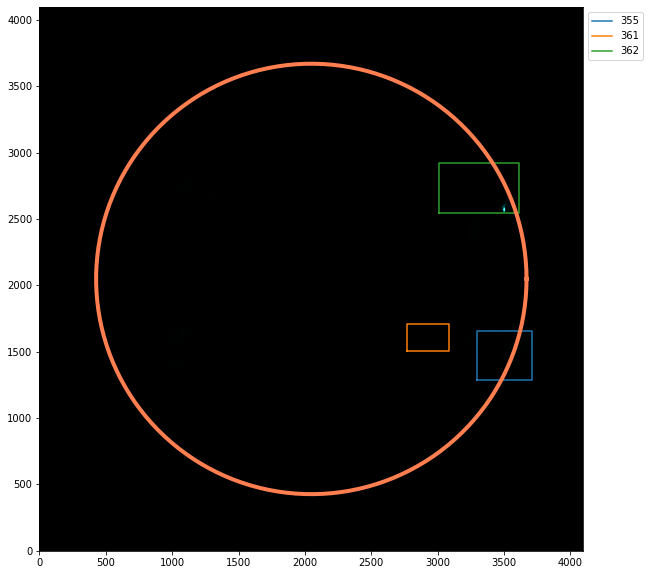

In [43]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

ax.set_ylim(0,4096)
ax.set_xlim(0,4096)

for harp_num, group in joined_time_stamp.groupby(['HARPNUM']):


    for _, row in group[:1].iterrows():

        # print(row['T_REC'])

        array_bbox = np.array(row.pixel_bbox_hmi)

        ax.plot(array_bbox[:,0], array_bbox[:,1], label = harp_num)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

cmap_dict = {94: 'sdoaia94', 131: 'sdoaia131', 171: 'sdoaia171', 193:'sdoaia193', 211: 'sdoaia211', 335:'sdoaia335', 304: 'sdoaia304', 'TM': 'sohoeit304', 'PTHK': 'sohoeit195', 'PTHNA': 'sohoeit284'}
cluster_color_dict = {0: 'blue', 1: 'orange', 2: 'green', 3: 'purple'}
id_team_dict = {'SolarSoft': 'yellow', 'SWPC': 'red'}
def make_circle_xy(radius, center):
    theta = np.linspace( 0 , 2 * np.pi , 150 )

    radius = radius

    r_1,r_2 = center[0], center[1]

    a = r_1 + radius * np.cos( theta )
    b = r_2 + radius * np.sin( theta )

    return(a,b)

circle = make_circle_xy(r_sun, (raw_header['CRPIX1'],raw_header['CRPIX1']))

ax.plot(circle[0],circle[1], linewidth = 4, color = 'coral')
ax.imshow(raw_data, origin = 'lower',  cmap = cmap_dict[this_dict['wavelength']])
# ax.scatter(x1,y1)
# ax.scatter(x2,y2)

In [44]:
import sunpy.map
my_map = sunpy.map.Map(raw_data, raw_header)
my_map.coordinate_frame

<Helioprojective Frame (obstime=2011-02-08T21:11:33.620, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2011-02-08T21:11:33.620): (lon, lat, radius) in (deg, deg, m)
    (-0.00994604, -6.50434523, 1.47545167e+11)>)>

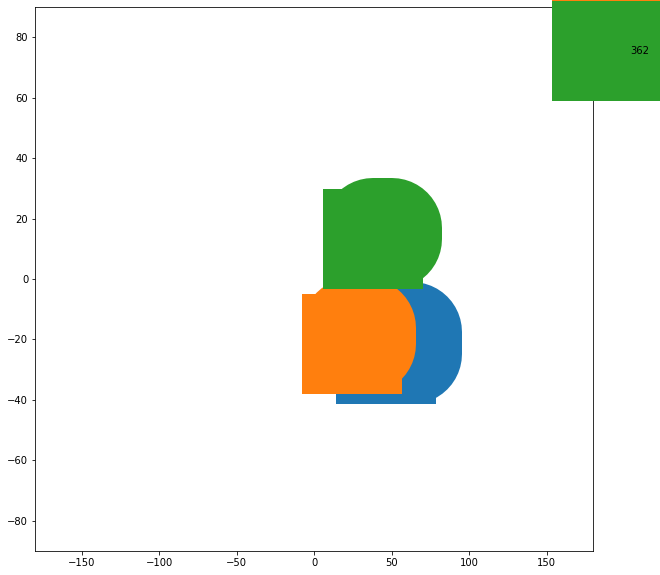

In [59]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)



# my_map = sunpy.map.Map(raw_data, raw_header)


ax.set_ylim(-90,90)
ax.set_xlim(-180,180)


for harp_num, group in joined_time_stamp.groupby(['HARPNUM']):

    for _, row in group[:1].iterrows():

        array_bbox = np.array(row.hgs_bbox)

        ax.plot(array_bbox[:,0], array_bbox[:,1], label = harp_num, linewidth = 100)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# ax.set_ylim(-40,40)
# ax.set_xlim(-100,100)

# my_map.plot(axes=ax)

In [46]:
joined_time_stamp

,DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,NOAA_AR,NOAA_ARS,NOAA_NUM,...,QUALITY,T_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS,CRSIZE1,CRSIZE2,hgs_bbox,pixel_bbox_hmi
0,1.297037e+09,355,1.296084e+09,1.296171e+09,1.297225e+09,1.297139e+09,1.297037e+09,11150,[11150],1,...,0,2011-02-06 23:59:26+00:00,1.495979e+11,1.475174e+11,696000000.0,973.179138,421,365,"[[46.128727, -24.717997], [46.128727, -17.3902...","[[3293.431152, 1288.756104], [3293.431152, 165..."
1,1.297037e+09,355,1.296084e+09,1.296171e+09,1.297225e+09,1.297139e+09,1.297037e+09,11150,[11150],1,...,0,2011-02-07 00:11:26+00:00,1.495979e+11,1.475193e+11,696000000.0,973.166626,420,365,"[[46.235516, -24.716084], [46.235516, -17.3978...","[[3295.394288, 1288.6933600000002], [3295.3942..."
2,1.297038e+09,355,1.296084e+09,1.296171e+09,1.297225e+09,1.297139e+09,1.297038e+09,11150,[11150],1,...,0,2011-02-07 00:23:26+00:00,1.495979e+11,1.475212e+11,696000000.0,973.153992,419,365,"[[46.359268, -24.714752], [46.359268, -17.4000...","[[3298.406738, 1288.581298], [3298.406738, 165..."
3,1.297039e+09,355,1.296084e+09,1.296171e+09,1.297225e+09,1.297139e+09,1.297039e+09,11150,[11150],1,...,0,2011-02-07 00:35:26+00:00,1.495979e+11,1.475232e+11,696000000.0,973.140991,418,366,"[[46.469753, -24.710583], [46.469753, -17.4047...","[[3300.425292, 1287.6477060000002], [3300.4252..."
4,1.297040e+09,355,1.296084e+09,1.296171e+09,1.297225e+09,1.297139e+09,1.297040e+09,11150,[11150],1,...,0,2011-02-07 00:47:26+00:00,1.495979e+11,1.475251e+11,696000000.0,973.127930,418,365,"[[46.583893, -24.705784], [46.583893, -17.3983...","[[3302.387696, 1287.7663579999999], [3302.3876..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,1.297120e+09,362,1.296622e+09,1.296708e+09,1.297436e+09,1.297349e+09,1.297120e+09,11153,[11153],1,...,0,2011-02-07 23:11:26+00:00,1.495979e+11,1.475341e+11,696000000.0,973.068481,486,384,"[[50.965534, 13.016167], [50.965534, 17.406763...","[[3325.175782, 2506.780518], [3325.175782, 289..."
359,1.297121e+09,362,1.296622e+09,1.296708e+09,1.297436e+09,1.297349e+09,1.297121e+09,11153,[11153],1,...,0,2011-02-07 23:23:26+00:00,1.495979e+11,1.475359e+11,696000000.0,973.057251,485,384,"[[51.089298, 13.009995], [51.089298, 17.404959...","[[3328.20166, 2505.805908], [3328.20166, 2889...."
360,1.297122e+09,362,1.296622e+09,1.296708e+09,1.297436e+09,1.297349e+09,1.297122e+09,11153,[11153],1,...,0,2011-02-07 23:35:26+00:00,1.495979e+11,1.475376e+11,696000000.0,973.045593,484,384,"[[51.211311, 13.01713], [51.211311, 17.410921]...","[[3330.271728, 2505.851074], [3330.271728, 288..."
361,1.297122e+09,362,1.296622e+09,1.296708e+09,1.297436e+09,1.297349e+09,1.297122e+09,11153,[11153],1,...,0,2011-02-07 23:47:26+00:00,1.495979e+11,1.475394e+11,696000000.0,973.033630,483,385,"[[51.335545, 13.016658], [51.335545, 17.422953...","[[3332.307862, 2504.825196], [3332.307862, 288..."


In [47]:
# joined_time_stamp['pixel_bbox_2'] = [get_pixel_boundary_box(row) for _,row in joined_copy.iterrows()]

# joined_time_stamp.hgs_bbox.iloc[0], joined_time_stamp.CROTA2.iloc[0], joined_time_stamp.RSUN_OBS.iloc[0]

# joined_time_stamp[['hgs_bbox', 'CROTA2', 'RSUN_OBS', 'CDELT1']].iloc[0]

In [48]:
# crota2, rsun, cdelt1, crsize1, crsize2 = joined_time_stamp[ ['CROTA2', 'RSUN_OBS', 'CDELT1', 'CRSIZE1', 'CRSIZE2']].iloc[0]

# # lower left-hand corner
# x1_1 = (keys_ccd.IMCRPIX1[0] - keys_ccd.CRPIX1[0])
# y1_1 = (keys_ccd.IMCRPIX2[0] - keys_ccd.CRPIX2[0]) 


# np.abs(crsize1*np.cos(crota2)- crsize2*np.sin(crota2))*cdelt1

In [49]:
# abs(crsize2* np.cos(crota2)+ crsize1* np.sin(crota2))*cdelt1

In [50]:
# joined_time_stamp[ ['CRPIX1','CRPIX2']].iloc[0]

In [51]:
import os 
import dataconfig

WORKING_DIR = dataconfig.DATA_DIR_HMI_DRMS

cache_dir = f'{WORKING_DIR}/no_data_dir/'

print(cache_dir)

os.makedirs(cache_dir, exist_ok=True) 

/mnt/e/ALEXIS_data/hmi_drms_ar/no_data_dir/


In [52]:
import re 

# r'\d{4}.\d{2}.\d{2}-\d{4}.\d{2}.\d{2}_drms_dmi_AR.df.pickle'

file_to_check = '/mnt/e/ALEXIS_data/hmi_drms_ar/2016.09.07-2016.09.08_drms_dmi_AR.df.pickle'

file_reg_exp = re.findall(r'\d{4}.\d{2}.\d{2}-\d{4}.\d{2}.\d{2}_drms_dmi_AR.df.pickle',file_to_check )[0]

cache_missing_file_name = os.path.join(cache_dir, file_reg_exp)



with open(cache_missing_file_name, 'a'): os.utime(cache_missing_file_name, None)

In [53]:
import astropy.units as u
from astropy.coordinates import SkyCoord

from sunpy.coordinates import frames

coord = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=frames.HeliographicStonyhurst, obstime="2017-07-26",
             observer="earth")
coord
hgs_hpc_transform_obj = coord.transform_to(frames.Helioprojective)

arc_x, arc_y = hgs_hpc_transform_obj.Tx.value, hgs_hpc_transform_obj.Ty.value



In [54]:
from astropy import units as u

from sunpy.net import Fido
from sunpy.net import attrs as a

time_range = a.Time("2022-02-20 00:00:00", "2022-02-20 00:00:30")
aia_search = Fido.search(time_range,
                         a.Instrument.aia,
                         a.Wavelength(171*u.angstrom))
aia_search




Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2022-02-20 00:00:09,2022-02-20 00:00:10,SDO,AIA,FULLDISK,171.0 .. 171.0
2022-02-20 00:00:21,2022-02-20 00:00:22,SDO,AIA,FULLDISK,171.0 .. 171.0


In [55]:
import coordinate_conversion_module

coordinate_conversion_module.hpc_to_pix()

TypeError: hpc_to_pix() missing 2 required positional arguments: 'coord_pair' and 'raw_header'